In [8]:
import sys
sys.path.append('../src')
from preamble import *

# get data files
files_dict = walk_directory(raw_data)

Andrew_diaper c:\Users\SESA703683\github\andrews_baby_tracker\data\raw\Andrew_diaper.csv
Andrew_expressed c:\Users\SESA703683\github\andrews_baby_tracker\data\raw\Andrew_expressed.csv
Andrew_formula c:\Users\SESA703683\github\andrews_baby_tracker\data\raw\Andrew_formula.csv
Andrew_growth c:\Users\SESA703683\github\andrews_baby_tracker\data\raw\Andrew_growth.csv
Andrew_milestone c:\Users\SESA703683\github\andrews_baby_tracker\data\raw\Andrew_milestone.csv
Andrew_nursing c:\Users\SESA703683\github\andrews_baby_tracker\data\raw\Andrew_nursing.csv
Andrew_other_activity c:\Users\SESA703683\github\andrews_baby_tracker\data\raw\Andrew_other_activity.csv
Andrew_sleep c:\Users\SESA703683\github\andrews_baby_tracker\data\raw\Andrew_sleep.csv
Andrew_temperature c:\Users\SESA703683\github\andrews_baby_tracker\data\raw\Andrew_temperature.csv
pump c:\Users\SESA703683\github\andrews_baby_tracker\data\raw\pump.csv


In [9]:
drews_data = list(files_dict.keys())
drews_data.remove('pump')
drews_data.remove('Andrew_sleep') # not tracked
for file in drews_data:
    print(file)
    display(pd.read_csv(files_dict[file]).head())

Andrew_diaper


,Baby,Time,Status,Note
0,Andrew,8/19/23 1:54 AM,Mixed,Pooped black and wet
1,Andrew,8/19/23 9:15 AM,Mixed,black sticky stuff again. large
2,Andrew,8/19/23 1:30 PM,Wet,Peed medium
3,Andrew,8/19/23 2:00 PM,Mixed,Peed and pooped (non meconiun) with Drs post c...
4,Andrew,8/19/23 11:15 PM,Mixed,NaN


Andrew_expressed


,Baby,Time,Amount (oz.),Note
0,Andrew,8/28/23 1:30 PM,0.4,NaN


Andrew_formula


,Baby,Time,Amount (oz.),Note
0,Andrew,8/22/23 10:30 AM,0.50,first formula. Similac Advanced
1,Andrew,8/22/23 1:00 PM,1.25,Vitamin D drop 400 IU
2,Andrew,8/22/23 4:05 PM,1.12,NaN
3,Andrew,8/22/23 7:15 PM,1.00,NaN
4,Andrew,8/22/23 11:25 PM,1.25,Spit up quite a bit. Was sleepy most of the ti...


Andrew_growth


,Baby,Time,Length (inches),Weight (lbs.),Head Size (inches),Note
0,Andrew,8/18/23 5:00 PM,19.5,3.23,NaN,at birth
1,Andrew,8/19/23 10:30 AM,19.5,3.03,NaN,NaN
2,Andrew,8/21/23 9:00 AM,19.5,2.86,NaN,NaN
3,Andrew,8/23/23 1:24 PM,NaN,2.89,NaN,NaN
4,Andrew,8/24/23 9:10 AM,NaN,2.95,NaN,6 lb 8.4 oz by lactation specialist before fee...


Andrew_milestone


,Baby,Time,Milestone,Note
0,Andrew,8/20/23 2:30 PM,Back home,NaN


Andrew_nursing


,Baby,Time,Start side,Left duration (min),Right Duration (min),Total (min),Note
0,Andrew,8/18/23 6:45 PM,Left,20.0,NaN,NaN,NaN
1,Andrew,8/18/23 11:00 PM,Left,15.0,15.0,NaN,NaN
2,Andrew,8/19/23 7:00 AM,Right,NaN,25.0,NaN,NaN
3,Andrew,8/19/23 7:13 AM,Left,1.0,13.0,NaN,Delayed start time add extra 8 min
4,Andrew,8/19/23 7:29 AM,Left,33.0,NaN,NaN,NaN


Andrew_other_activity


,Baby,Time,Other activity,Duration (min),Note
0,Andrew,8/23/23 9:13 AM,play time,NaN,NaN
1,Andrew,8/23/23 9:30 AM,Tummy Time,10.0,crawled up daddy's chest 3 or 4 times and lift...
2,Andrew,8/25/23 9:20 PM,wipe down with hand towel and warm water,NaN,NaN


Andrew_temperature


,Baby,Time,Temperature (°F),Note
0,Andrew,8/21/23 2:45 AM,98.3,armpit


In [10]:
from datetime import timedelta
def get_data(filename):
    return (pd.read_csv(filename)
             .drop(columns=['Baby'])
             .assign(Time= lambda x: pd.to_datetime(x.Time))
             .set_index('Time',drop=True))

def get_days_between(datePast, dateFuture):
   difference = dateFuture - datePast
   return difference.total_seconds() / timedelta(days=1).total_seconds()

In [11]:

diaper_df = get_data(files_dict['Andrew_diaper'])

diaper_df.head()

,Status,Note
Time,,
2023-08-19 01:54:00,Mixed,Pooped black and wet
2023-08-19 09:15:00,Mixed,black sticky stuff again. large
2023-08-19 13:30:00,Wet,Peed medium
2023-08-19 14:00:00,Mixed,Peed and pooped (non meconiun) with Drs post c...
2023-08-19 23:15:00,Mixed,NaN


<AxesSubplot: xlabel='Time', ylabel='Status'>

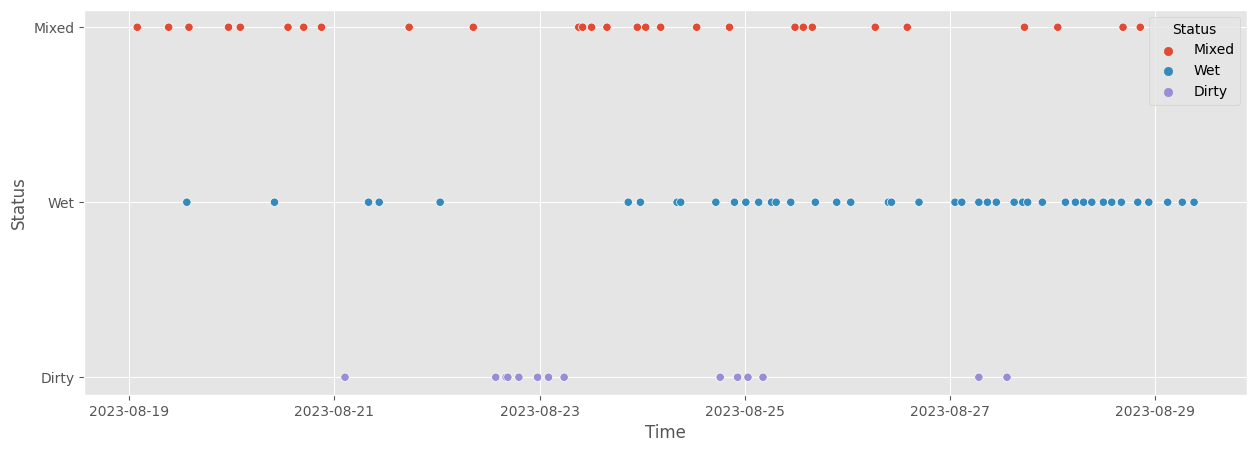

In [12]:
sns.scatterplot(data=diaper_df,x='Time',y='Status',hue='Status')

## Predict Return to Birth Weight

In [13]:
import statsmodels.api as sm

growth_df = get_data(files_dict['Andrew_growth'])
growth_df['days'] = [get_days_between(growth_df.index[0],x) for x in growth_df.index]
started_eating_filter = growth_df.days>2
model = sm.OLS(growth_df[started_eating_filter]['Weight (lbs.)'].values,
             sm.add_constant(growth_df[started_eating_filter].days.values))
res = model.fit()
pred_ols = res.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]
growth_df['pred'] = np.append(np.full(sum(~started_eating_filter), fill_value=np.nan),res.fittedvalues)
growth_df

,Length (inches),Weight (lbs.),Head Size (inches),Note,days,pred
Time,,,,,,
2023-08-18 17:00:00,19.5,3.23,NaN,at birth,0.000000,NaN
2023-08-19 10:30:00,19.5,3.03,NaN,NaN,0.729167,NaN
2023-08-21 09:00:00,19.5,2.86,NaN,NaN,2.666667,2.849564
2023-08-23 13:24:00,NaN,2.89,NaN,NaN,4.850000,2.911799
2023-08-24 09:10:00,NaN,2.95,NaN,6 lb 8.4 oz by lactation specialist before fee...,5.673611,2.935276
2023-08-26 09:43:00,NaN,2.99,NaN,6 lb 9.5 oz,7.696528,2.992939
2023-08-27 09:07:00,NaN,3.00,NaN,NaN,8.671528,3.020731
2023-08-28 09:30:00,NaN,3.07,NaN,6 lb 12.1 oz,9.687500,3.049691


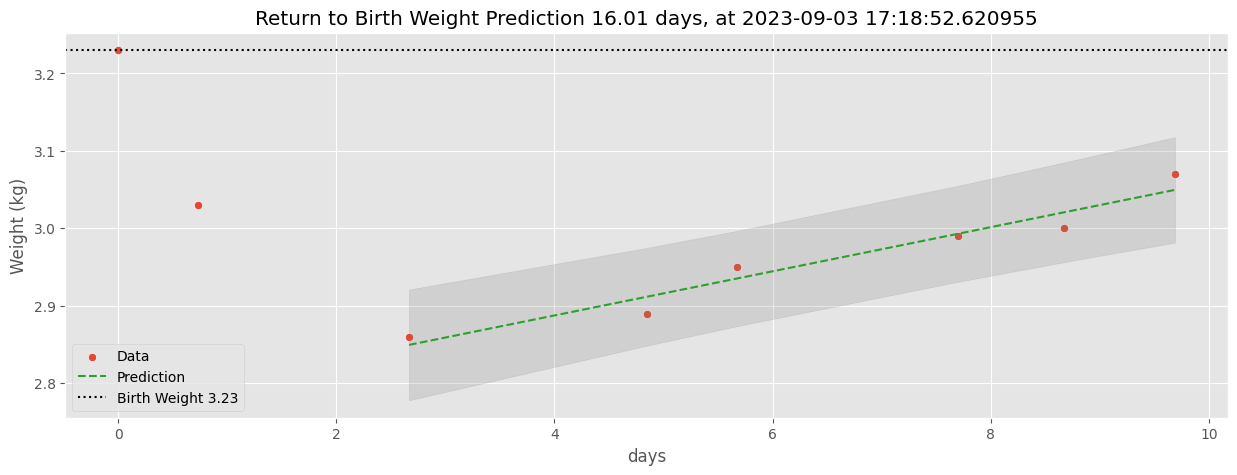

In [14]:
birth_weight = growth_df.at[growth_df.index[0],'Weight (lbs.)']
ax = sns.scatterplot(data=growth_df,x='days',y='Weight (lbs.)',label='Data')
ax = sns.lineplot(data=growth_df[started_eating_filter],x='days',y='pred',color='tab:green',
                  linestyle='dashed',label='Prediction')
ax.axhline(birth_weight,label=f'Birth Weight {birth_weight:0.2f}',color='k',linestyle='dotted')
ax.fill_between(growth_df[started_eating_filter].days,
    iv_l, iv_u, color='tab:gray', alpha=0.2)
return_to_birth_weight = (birth_weight - res.params[0])/res.params[1]
r2bw_date = growth_df.index[0] + timedelta(days=return_to_birth_weight)
ax.set_title(f'Return to Birth Weight Prediction {return_to_birth_weight:0.2f} days, at {r2bw_date}')
ax.set_ylabel('Weight (kg)')

_=ax.legend()

In [16]:
formula_df = get_data(files_dict['Andrew_formula'])
formula_df['hour_of_day'] = [x.hour for x in formula_df.index]
formula_df

,Amount (oz.),Note,hour_of_day
Time,,,
2023-08-22 10:30:00,0.50,first formula. Similac Advanced,10
2023-08-22 13:00:00,1.25,Vitamin D drop 400 IU,13
2023-08-22 16:05:00,1.12,NaN,16
2023-08-22 19:15:00,1.00,NaN,19
2023-08-22 23:25:00,1.25,Spit up quite a bit. Was sleepy most of the ti...,23
...,...,...,...
2023-08-29 00:54:00,1.60,NaN,0
2023-08-29 03:00:00,0.90,NaN,3
2023-08-29 06:10:00,1.30,NaN,6


<AxesSubplot: xlabel='hour_of_day', ylabel='Amount (oz.)'>

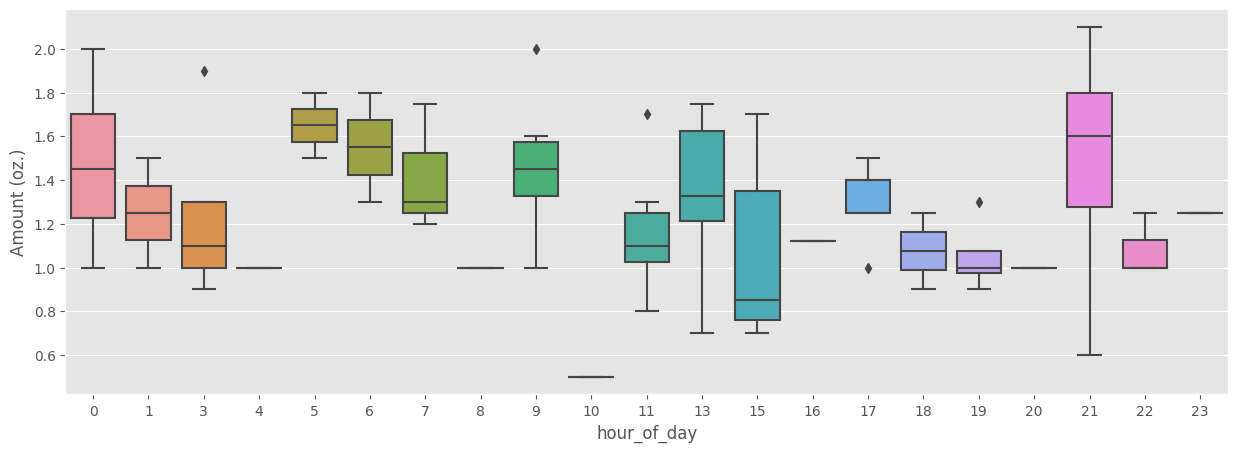

In [21]:
sns.boxplot(data=formula_df,y='Amount (oz.)',x='hour_of_day')